# Finalize clusters

- removes unwanted (empty) clusters.
- splits big cluster mannualy.
- save final clusters - mapping between barcodes and clusters
- finds final markers
- creates final heatmap
- save tSNE with barcodes

In [87]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
lib6 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts/preprocess_data'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
sys.path.append(lib6)
from classifying_cell_types import *
from utilities.general_helpers import *
# ------- SERVER EXTENSIONS ---------
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
from utilities.ML_environment import find_marker_genes_in_cluster
import pickle
# from Bio.Cluster import kcluster
# from Bio.Cluster import kcluster
# import pyclustering
from utilities.ML_environment import find_marker_genes_in_cluster
import os
import numpy as np
import yaml
from os.path import join
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import statsmodels as sm
import scipy.stats as stats
from scipy.stats import rankdata
from sklearn.manifold import TSNE
import pickle
import numpy as np
from utilities.general_helpers import flatten_list
# from utilities.ML_environment import find_marker_genes_in_cluster
from shutil import copyfile
import matplotlib.pyplot as plt
from utilities.clustering_tools import find_marker_genes_in_cluster, find_markers_in_clusters
from utilities.general_helpers import are_the_lists_identical

In [65]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21_protein_coding_genes.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'

In [66]:
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

Loading cohort file:
/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21_protein_coding_genes.pkl


In [4]:
K = 15
kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans/kmeans_immune_cells_4k_genes_k_15.pkl


In [6]:
clusters_cells = [filtered_cells[cluster_indices] for cluster_indices in clusters]

# Creates DF

removes clusters (the corresponding barcodes) from the DF.
clusters indexes in DF will be serial starts from 1, and not compatible with original cluster numbers.

In [7]:
df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster'])

# [cls.number_of_cells for cls in clusters_cells]
cluster_idx = 1
for idx, cls in enumerate(clusters_cells):  
    if cls.number_of_cells > 30:
        df = df.append(pd.DataFrame(transpose_list([cls.samples, cls.barcodes, [cluster_idx]*cls.number_of_cells]), columns=df.columns))
        cluster_idx += 1
    else:
        print(f'cluster {idx+1} contains {cls.number_of_cells} cells (less than 30 cells) and therefore excluded from DF')
df = df.reset_index()

cluster 2 contains 2 cells (less than 30 cells) and therefore excluded from DF
cluster 6 contains 3 cells (less than 30 cells) and therefore excluded from DF
cluster 9 contains 1 cells (less than 30 cells) and therefore excluded from DF
cluster 13 contains 1 cells (less than 30 cells) and therefore excluded from DF


In [21]:
df.groupby('Cluster').count().reset_index()

,Cluster,index,Sample,Barcode
0,1,15181,15181,15181
1,2,4537,4537,4537
2,3,3385,3385,3385
3,4,2950,2950,2950
4,5,12924,12924,12924
5,6,10061,10061,10061
6,7,4726,4726,4726
7,8,10521,10521,10521
8,9,6522,6522,6522
9,10,3341,3341,3341


##### Saves final DF of mapping

if you want to split some clusters, don't save yet. only after you finish the next step.

In [ ]:
# CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
# df.to_csv(CSV_PATH)

# Splits cluster using tSNE

If there's a big cluster where you see in heatmaps that the markers assoicated with half of the cells, you can split it to two.

If not - just skip these blicks.

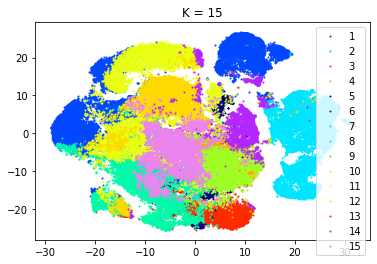

In [24]:
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_26.6.21/immune_cells_bhtsne_26.6.21.pkl'

cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,15)])[[2, 5, 11, 10, 0, 1, 3, 4, 6, 7, 8, 9, 12, 13, 14]]


for cluster_idx, cluster_list in enumerate(clusters):
    Xi = cells_embedded[cluster_list, 0]
    Yi = cells_embedded[cluster_list, 1]
    plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx], label=cluster_idx+1, markersize=1)

    plt.legend()
plt.title(f"K = {K}");
plt.show()


In [43]:
cluster_1 = clusters[0]
Xi = cells_embedded[cluster_1, 0]
Yi = cells_embedded[cluster_1, 1]
left_side_indices = np.array(cluster_1)[Xi < -5]
right_side_indices = np.array(cluster_1)[Xi >= -5]
left_cluster = filtered_cells[left_side_indices]
right_cluster = filtered_cells[right_side_indices]

In [42]:
# Sanity check - should be TRUE (identical)
are_the_lists_identical(left_cluster.barcodes + right_cluster.barcodes, df[df['Cluster']==1]['Barcode'].tolist())

True

In [44]:
df['Cluster'] = df.apply(lambda x: 12 if x['Barcode'] in left_cluster.barcodes else x['Cluster'], axis=1)
df.groupby('Cluster').count()

,index,Sample,Barcode
Cluster,,,
1,6431,6431,6431
2,4488,4488,4488
3,3336,3336,3336
4,2922,2922,2922
5,12780,12780,12780
6,9943,9943,9943
7,4670,4670,4670
8,10408,10408,10408
9,6434,6434,6434


##### Saves final DF of mapping

In [45]:
CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
df.to_csv(CSV_PATH)

# find marker genes in final clusters
Mainly for drawing a heatmap

In [67]:
CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
df = pd.read_csv(CSV_PATH)

In [89]:
# just to see the size of the clusters
# df.groupby('Cluster').count()

In [81]:
def get_clusters_indices(df):
    mapping = list(zip(filtered_cells.samples, filtered_cells.barcodes))
    clusters = sorted(set(df['Cluster']))
    clusters_indexes = []
    for cluster_idx in clusters:
        barcodes_list = df[df['Cluster']==cluster_idx]['Barcode'].tolist()
        sample_list = df[df['Cluster']==cluster_idx]['Sample'].tolist()
        cell_idxs = [mapping.index(pair_identifier) for pair_identifier in zip(sample_list, barcodes_list)]
        clusters_indexes.append(cell_idxs)
    return clusters_indexes
clusters_indexes = get_clusters_indices(df)

In [158]:
cluster_markers_list = find_markers_in_clusters(filtered_cells, clusters_indexes)

Progress: 1/12
Progress: 2/12
Progress: 3/12
Progress: 4/12
Progress: 5/12
Progress: 6/12
Progress: 7/12
Progress: 8/12
Progress: 9/12
Progress: 10/12
Progress: 11/12
Progress: 12/12


In [159]:
print(f'number of markers in each cluster before/after mediating marker definition')
print([len(v['markers']) for v in cluster_markers_list])
for idx, cluster_markers in enumerate(cluster_markers_list):
    cluster_id = cluster_markers['cluster id']
    markers = cluster_markers['markers']
    if len(markers) < 30:
        print(cluster_id)
        current_cluster_indices = clusters_indexes[cluster_id]
        other_clusters_indices = [ii for ii in flatten_list(clusters_indexes) if not ii in clusters_indexes[cluster_id]]
        cluster_markers = find_marker_genes_in_cluster(filtered_cells[current_cluster_indices], filtered_cells[other_clusters_indices], log_FC_threshold = 0.25, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.05)
        cluster_markers_list[idx] = {'cluster id': cluster_id, 'markers': cluster_markers}
print([len(v['markers']) for v in cluster_markers_list])

[238, 1418, 145, 175, 1331, 72, 242, 223, 36, 1741, 16, 53]
10
[238, 1418, 145, 175, 1331, 72, 242, 223, 36, 1741, 32, 53]


##### Saves the PKL version

In [162]:
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21'
K = 12
pickle.dump((cluster_markers_list), open(os.path.join(OUTPUT_PATH, f'cluster_analysis_k_{K}.pkl'), 'wb'))

##### Saves the Excel version

In [193]:
markers_df = pd.DataFrame()
for cluster_markers in cluster_markers_list:
    gene_markers = cluster_markers['markers']['gene names'].tolist()[:100]
    if len(gene_markers) <100:
        gene_markers += [None] * (100 - len(gene_markers))
    markers_df[cluster_markers['cluster id']+1] = gene_markers


In [195]:
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21/markers.csv'

markers_df.to_csv(OUTPUT_PATH)

# tSNE

##### Runs the next block only if you start the run from here:

In [ ]:
# CSV_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
# df = pd.read_csv(CSV_PATH)
# clusters_indexes = get_clusters_indices(df)

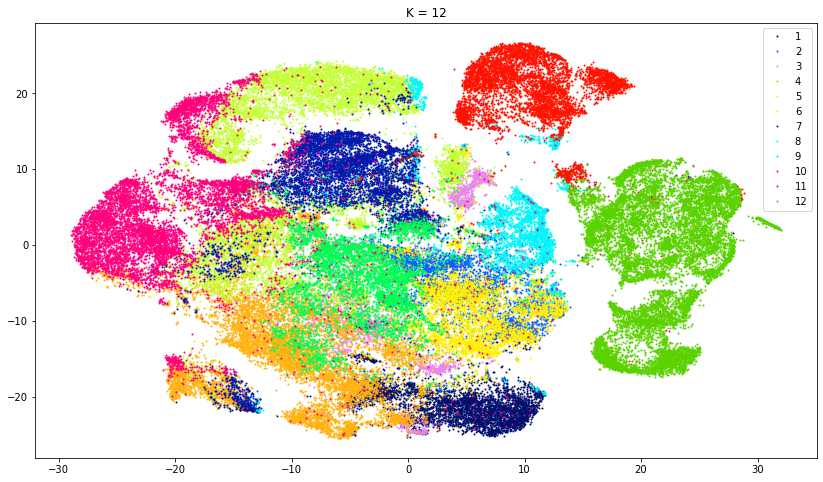

In [238]:
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/clustering/summeries/26.6.21/tSNE.png'
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_26.6.21/immune_cells_bhtsne_26.6.21.pkl'



plt.rcParams["figure.figsize"] = 14, 8 #plt.rcParamsDefault["figure.figsize"]

cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[1, 15, 99, 70, 60, 53,  10, 23,  32,  84, 80, 40, 12, 13, 14]]


for cluster_idx, cluster_list in enumerate(np.array(clusters_indexes)[[1,2,3,5,6,7,8,9,10,11,0, 4]]):
    Xi = cells_embedded[cluster_list, 0]
    Yi = cells_embedded[cluster_list, 1]
    plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx], label=cluster_idx+1, markersize=1)

    plt.legend()
plt.title(f"K = {K}");
# plt.show()

# remove if you dont want to save
plt.savefig(OUTPUT_PATH)

# Debug

In [108]:
K=15
CLUSTERING_ANALYSIS_PATH = fr'/storage/md_keren/shitay/outputs/clustering/cluster_analysis/cluster_analysis_26.6.21'
clustering_analysis = pickle.load(open(join(CLUSTERING_ANALYSIS_PATH, f'cluster_analysis_k_{K}.pkl'), 'rb'))

In [109]:
clustering_analysis
[len(v['markers']) for v in clustering_analysis]


[93, 0, 1445, 154, 178, 3, 1346, 74, 0, 252, 228, 37, 1, 1757, 17]